# Symbolic Regression

## Note: Run all the code cells below in order to ensure everything runs correctly 

For this lab, we are going to focus on a different kind of evolutionary algorithm than genetic algorithms. This lab will be focused on genetic programming.

Genetic programming is an evolutionary approach to generating computer programs. GP is the tool we will use for automated algorithm design.

We will start by importing the libraries we need for GP.

In [1]:
import random
import operator

import numpy as np
import matplotlib.pyplot as plt

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

Next, we will create our fitness and individual classes.

In [2]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

This time our individual class inherits from DEAP's PrimitiveTree class instead of a list. This is because our individuals will be represented as a tree structure. Trees are the most common data structure used in GP. In GP, trees are made of functions and variables called primitives. Each primitive is a node in the tree where the leaves of a node are the inputs to the parent node. When we evaluate each individual we simply compile the primitive tree from its leaves to its root node.

The source code for PrimitiveTree and gp.compile can be found here: https://github.com/DEAP/deap/blob/master/deap/gp.py

Next, we will initialize a primitive set and add all the primitives our trees can use.

In [3]:
pset = gp.PrimitiveSet("MAIN", arity=1)
pset.addPrimitive(np.add, arity=2)
pset.addPrimitive(np.subtract, arity=2)
pset.addPrimitive(np.multiply, arity=2)
pset.addPrimitive(np.negative, arity=1)
pset.renameArguments(ARG0='x')

We added several mathematical operators to our primitive set. We also renamed the default first argument name in DEAP to x instead of ARG0. The arity parameter we defined specifies the amount of arguments each primitive takes.

Add at least two new primitives in the code cell below.

In [4]:
pset.addPrimitive()
pset.addPrimitive()

TypeError: addPrimitive() missing 2 required positional arguments: 'primitive' and 'arity'

Next we will define our toolbox, individual, population, and compiler.

In [5]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

By now this format should look familar to you. The major difference here is the "expr" function we defined. gp.genHaldandHalf returns a primitive tree based on a primitive set and a minimum and maximum tree depth. In this case the primitive set is the one we defined earlier, the minimum depth is 1, and the maxmimum depth is 2. I encourage you to change the minimum and maximum depth and observe the results.

Next, we will define our evaluation function.

In [6]:
def evalSymbReg(individual, points, pset):
    func = gp.compile(expr=individual, pset=pset)
    sqerrors = (func(points)-(points**4 + points**3 + points**2 + points))**2
    return (np.sqrt(np.sum(sqerrors) / len(points)),)

To evaluate our primitive tree we first compile the tree into a function. Then, we calculate the function and determine the mean squared error between the function we compile and the actual function we are trying to generate. We are optimizing the function we are generating by minimizing mean squared error.

We are not trying to fit a function to data though. We are trying to generate a specific output. We already know what the ideal function is and our primitive set contains all the primitives used by the ideal function. However, you could think of genetic programming as finding the best combination of primitives given objectives to minimize or maximize. This means we care a lot less about data than machine learning and care more about objectives.

Next, we will register our genetic operators.

In [7]:
toolbox.register("evaluate", evalSymbReg, points=np.linspace(-1, 1, 1000), pset=pset)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

Add at least one more mutation method in the code cell below and try out this mutation method in the evolutionary loop found further below.

You can find more GP mutations in the DEAP source code here: https://github.com/DEAP/deap/blob/master/deap/gp.py

In [8]:
toolbox.register()

TypeError: register() missing 2 required positional arguments: 'alias' and 'function'

You can optionally add tree height contraints to our mutation and crossover functions.

In [10]:
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

Next, we will program the main evolutionary algorithm.

In [11]:
gen = range(40)
avg_list = []
max_list = []
min_list = []

pop = toolbox.population(n=300)

# Evaluate the entire population
fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

# Begin the evolution
for g in gen:
    print("-- Generation %i --" % g)

    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.5:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < 0.2:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Replace population
    pop[:] = offspring

    # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in pop]

    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x*x for x in fits)
    std = abs(sum2 / length - mean**2)**0.5
    g_max = max(fits)
    g_min = min(fits)
        
    avg_list.append(mean)
    max_list.append(g_max)
    min_list.append(g_min)

    print("  Min %s" % g_min)
    print("  Max %s" % g_max)
    print("  Avg %s" % mean)
    print("  Std %s" % std)

print("-- End of (successful) evolution --")

best_ind = tools.selBest(pop, 1)[0]
print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))

-- Generation 0 --
  Min 0.4112027678437573
  Max 2.225930565212586
  Avg 1.0033061125603873
  Std 0.285041691563565
-- Generation 1 --
  Min 0.4112027678437573
  Max 2.225930565212586
  Avg 0.8846069762929113
  Std 0.27201575049825344
-- Generation 2 --
  Min 0.159284112731791
  Max 2.225930565212586
  Avg 0.8025425644965207
  Std 0.3106444008106467
-- Generation 3 --
  Min 0.159284112731791
  Max 2.225930565212586
  Avg 0.7228867777673819
  Std 0.3232900005036636
-- Generation 4 --
  Min 0.159284112731791
  Max 2.1134173679263952
  Avg 0.6534282890895204
  Std 0.34443990666944135
-- Generation 5 --
  Min 0.159284112731791
  Max 2.149016196642197
  Avg 0.5737916574481846
  Std 0.32733896800811424
-- Generation 6 --
  Min 8.620776339403237e-17
  Max 2.225930565212586
  Avg 0.5193060519412493
  Std 0.3234835840222894
-- Generation 7 --
  Min 8.620776339403237e-17
  Max 1.7657884004983495
  Avg 0.5098925526610214
  Std 0.3233123884592145
-- Generation 8 --
  Min 8.620776339403237e-17
  M

The format above should look familar to you. It's the same evolutionary loop we used in Lab 1.

The format of the best individual above is different from the list format of our previous problems. The individual is printed out in a tree format being read from left to right. There are ways to visualize the individual tree. However, this lab will not cover how to visualize the individual. I encourage you to look up networkx and graphviz if you are interested.

Next, we will add graphing.

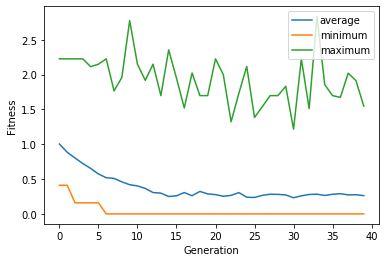

In [12]:
plt.plot(gen, avg_list, label="average")
plt.plot(gen, min_list, label="minimum")
plt.plot(gen, max_list, label="maximum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper right")
plt.show()

Experiment with the parameters of the above genetic programming to improve the results.

# Multi-Objective Genetic Programming

### With Symbolic Regression

To demonstrate multi-objective optimization, we are going to modify our code above.

First, we will create new fitness and individual classes for a multiobjective problem.

In [13]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

c:\python37\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
c:\python37\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


We will minimize two objectives, mean squared error and the size of our tree.

Next, we are going to add three new primitives to our primitive set and set a seed for randomization. We will also reinitialize our toolbox to make sure all of our tools work properly.

In [14]:
random.seed(25)

pset = gp.PrimitiveSet("MAIN", arity=1)
pset.addPrimitive(np.add, arity=2)
pset.addPrimitive(np.subtract, arity=2)
pset.addPrimitive(np.multiply, arity=2)
pset.addPrimitive(np.negative, arity=1)
pset.addPrimitive(np.sin, arity=1)
pset.addPrimitive(np.cos, arity=1)
pset.addPrimitive(np.tan, arity=1)
pset.renameArguments(ARG0='x')

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

We reinitialized our primitive set and set a seed for randomization to ensure everyone produces the same results. The three primitives we added will be used in our updated evaluation function in the next step.

Next, we will add another objective to our evaluation function and change the problem into a more difficult one. We will also reinitialize the rest of our toolbox functions. 

In [15]:
def evalSymbReg(individual, points, pset):
    func = gp.compile(expr=individual, pset=pset)
    sqerrors = (func(points)-(np.negative(points) + np.sin(points**2) + np.tan(points**3) - np.cos(points)))**2

    return (np.sqrt(np.sum(sqerrors) / len(points)), len(individual))


toolbox.register("evaluate", evalSymbReg, points=np.linspace(-1, 1, 1000), pset=pset)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

Our symbolic regression problem has been replaced with a much harder equation to solve. This is designed to show more evolution over time than the previous problem. This problem will not be solved within 100 iterations. We also return the length of the individual tree, which returns the amount of nodes in that individual tree. We will make changes to our evolutionary process to optimize both objectives.

However, in this example we will first create a visualization of our objective space to help illustrate the pareto dominance we will use later on.

Next, we will define our pareto dominance function. We will use this function when we visualize our objective space.

In [16]:
def pareto_dominance(ind1, ind2):
    not_equal = False
    for value_1, value_2 in zip(ind1.fitness.values, ind2.fitness.values):
        if value_1 > value_2:
            return False
        elif value_1 < value_2:
            not_equal = True
    return not_equal

Our pareto dominance function returns true if the first individual dominates the second individual.

Next, we will initialize a random population of 300 individuals and initialize one separate individual for comparison.

In [17]:
pop = toolbox.population(n=300)

fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

a_given_individual = toolbox.population(n=1)[0]
a_given_individual.fitness.values = toolbox.evaluate(a_given_individual)

Next, we will sort our population by pareto dominance in comparison to the separate individual we defined.

In [18]:
dominated = [ind for ind in pop if pareto_dominance(a_given_individual, ind)]
dominators = [ind for ind in pop if pareto_dominance(ind, a_given_individual)]
others = [ind for ind in pop if not ind in dominated and not ind in dominators]

Next, we will plot our objective space using our sorted population.

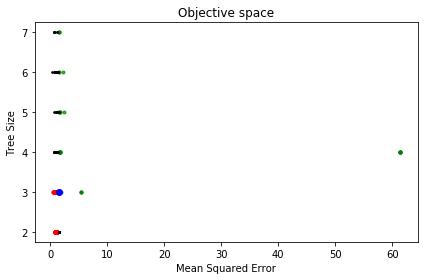

In [19]:
for ind in dominators: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'r.', alpha=0.7)
for ind in dominated: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'g.', alpha=0.7)
for ind in others: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', alpha=0.7, ms=3)
plt.plot(a_given_individual.fitness.values[0], a_given_individual.fitness.values[1], 'bo', ms=6);
plt.xlabel('Mean Squared Error');plt.ylabel('Tree Size');
plt.title('Objective space');
plt.tight_layout()
plt.show()

The blue point is the given individual we set aside and compared all the other individuals to. The black points are uncomparable, the green points are dominated by the given individual, and the red points dominate the given individual.

We can see in this visualization how the individuals dominating our pareto front are closer to the bottom right because they have the lowest MSE and tree size. Our goal is to minimize both objectives and have an individual as close to the bottom right as possible.

A more in-depth look at DEAP, pareto fronts, and pareto dominance can be found here: https://github.com/lmarti/evolutionary-computation-course/blob/master/AEC.06%20-%20Evolutionary%20Multi-Objective%20Optimization.ipynb

Next, we will define and run the main evolutionary algorithm.

In [20]:
NGEN = 50
MU = 50
LAMBDA = 100
CXPB = 0.5
MUTPB = 0.2

pop = toolbox.population(n=MU)
hof = tools.ParetoFront()
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, stats,
                          halloffame=hof)

gen	nevals	avg                    	std                    	min                    	max                    
0  	50    	[1.10650195 3.26      ]	[0.30401178 1.45340978]	[0.72012608 2.        ]	[1.55251825 7.        ]
1  	66    	[0.84741287 3.94      ]	[0.20331581 1.62984662]	[0.62937003 1.        ]	[1.49062507 7.        ]
2  	74    	[0.73152614 4.26      ]	[0.03894396 1.43958327]	[0.62937003 2.        ]	[0.82078751 7.        ]
3  	65    	[0.70577647 4.54      ]	[0.06045703 1.68772036]	[0.49416153 2.        ]	[0.82078751 7.        ]
4  	66    	[0.688637 4.38    ]    	[0.06643464 1.58606431]	[0.49416153 3.        ]	[0.72234418 7.        ]
5  	67    	[0.66372842 4.72      ]	[0.07364579 1.51049661]	[0.49416153 2.        ]	[0.82078751 7.        ]
6  	71    	[0.60540029 5.        ]	[0.08975108 1.42828569]	[0.38911481 3.        ]	[0.72234418 8.        ]
7  	66    	[0.51068731 5.06      ]	[0.07762804 2.12988263]	[0.37082423 3.        ]	[0.72012608 9.        ]
8  	67    	[0.49007428 5.2       ]	[0

Now, we will plot the results of our run and display the best individual.

Best individual is: negative(cos(multiply(add(cos(sin(cos(sin(cos(tan(x)))))), cos(x)), tan(x))))
with fitness: (0.2786133308027132, 15.0)


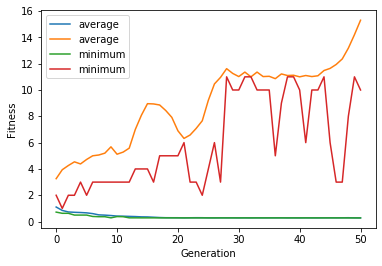

In [21]:
print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))
gen, avg, min_, max_ = logbook.select("gen", "avg", "min", "max")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper left")
plt.show()

In the graph above, the orange and red plots represent tree size and the blue and green plots represent MSE.

This time we made use of DEAP's efficient implementations of pareto dominance and evolutionary algorithms. We used DEAP's Mu plus Lambda evolutionary algorithm. This adds two new parameters than the evolutionary loop we are used to, mu and lambda. Mu is the number of individuals to select for the next generation. Lambda is the number of children to produce at each generation.

In the plot above, we can see two trends. The size of our primitive trees raises over time, and our mean squared error quickly drops to between 0 and 1 within the first few generations.

However, that plot does not accurately represent how well our population is doing on both objectives. We can use a visualization of our objective space to show our pareto front and accurately represent how well our population is doing on both objectives.

Next, we will visualize our objective space and pareto front.

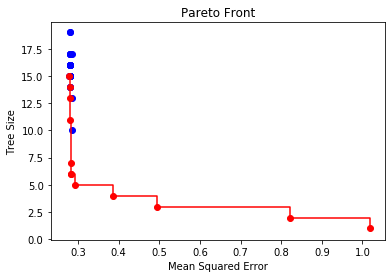

Area Under Curve: 2.3841416372199005


In [22]:
"""Split fitness values into separate lists"""
fitness_1 = [ind.fitness.values[0] for ind in hof]
fitness_2 = [ind.fitness.values[1] for ind in hof]
pop_1 = [ind.fitness.values[0] for ind in pop]
pop_2 = [ind.fitness.values[1] for ind in pop]

'''Print dominated population for debugging'''
# for ind in pop:
#     print(ind.fitness)

plt.scatter(pop_1, pop_2, color='b')
plt.scatter(fitness_1, fitness_2, color='r')
plt.plot(fitness_1, fitness_2, color='r', drawstyle='steps-post')
plt.xlabel("Mean Squared Error")
plt.ylabel("Tree Size")
plt.title("Pareto Front")
plt.show()

f1 = np.array(fitness_1)
f2 = np.array(fitness_2)

"""Calculate area under curve with least squares method"""
print("Area Under Curve: %s" % (np.sum(np.abs(np.diff(f1))*f2[:-1])))

DEAP's pareto front hall of fame gives us a list of the nondominated individuals after our evolution. We use that list and the last population to visualize our pareto front.

To measure the performance of our pareto front we use the area under the curve of the pareto front seen in the visualization. The lower our AUC is, the better our pareto front is.

Implement a version of the genetic programming problem above which produces at least a 25% decrease in the AUC.

# Strongly Typed Genetic Programming

## Note: You are not required to run the code in this section

In this section we will highlight more features of DEAP and genetic programming.

Documentation: http://deap.readthedocs.io/en/master/tutorials/advanced/gp.html

In [23]:
def if_then_else(input, output1, output2):
    return output1 if input else output2

pset = PrimitiveSetTyped("main", [bool, float], float)
pset.addPrimitive(operator.xor, [bool, bool], bool)
pset.addPrimitive(operator.mul, [float, float], float)
pset.addPrimitive(if_then_else, [bool, float, float], float)
pset.addTerminal(3.0, float)
pset.addTerminal(1, bool)

pset.renameArguments(ARG0="x")
pset.renameArguments(ARG1="y")

NameError: name 'PrimitiveSetTyped' is not defined

In the code above, we defined strongly typed primitives and terminals. Terminals are pre-defined constants for our individuals.

First, we defined our strongly typed primitive set with the PrimitiveSetTyped() method. The first argument defines the name of the primitive set. The second argument defines the input (leaf) nodes of each individual tree, and the third argument defines the output of each individual tree. In this case our leaf nodes consist of Booleans and floats put together.

Adding primitives follows the same structure of defining inputs and then outputs. For terminals, we define the value of the terminal and then its type.

<img src="files/images/trees.png">

The tree above on the left is a valid tree based on the primitive set we defined.
The tree on the right is invalid because XOR is given a float not equal to 1 or 0 instead of a Boolean value.

We have to be careful to not define primitives and terminals our trees cannot produce. This will lead to errors when we evolve our population.

## Ephemeral Constants

Ephermeral constants are terminals generated by a function instead of pre-defined values.

In [ ]:
pset.addEphemeralConstant(lambda: random.randint(-10, 10), int)

## Bloat Control

The last thing we will cover is limiting tree size and bloat control. DEAP trees can only have a maximum depth of 91 due to limitations in Python's parser. There are also many examples of GP problems where individuals bloat over time and increase in size.

In [ ]:
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

To prevent this, we can use static limits like the code shown above, set an objective to minimize tree size, and modify our evaluation function to give bloated trees worse fitness values.